# Tree Species Point Cloud Data Visualization

This notebook covers the essential data visualization phase of the tree species classification project.

## Project Structure:
1. Dataset download ✓ DONE
2. Train/test split ✓ DONE  
3. Data visualization ← Current phase
4. Feature extraction (LBP + FPFH) ← Next phase
5. Classification (RBF SVM) ← Final phase

## Current Task: 
Explore and visualize point cloud data to understand the dataset before feature extraction.

## 1. Dataset Structure Analysis

First, let's examine the folder structure and understand what we have.

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import os
import open3d as o3d

# Set up matplotlib for better plotting
plt.style.use('default')
%matplotlib inline

print("Libraries imported successfully")
print("Current working directory:", os.getcwd())

Libraries imported successfully
Current working directory: /Users/ayoub/work/prjt/notebooks


In [2]:
# Examine dataset folder structure
base_path = Path("..")  # Go up one level from notebooks folder

print("Project Structure:")
print("===================")

# Check if train and test folders exist
train_path = base_path / "train"
test_path = base_path / "test"

if train_path.exists() and test_path.exists():
    print("✓ Train and test folders found")
    
    # Count species in train folder
    train_species = [f.name for f in train_path.iterdir() if f.is_dir()]
    test_species = [f.name for f in test_path.iterdir() if f.is_dir()]
    
    print(f"✓ Train species: {len(train_species)}")
    print(f"✓ Test species: {len(test_species)}")
    print(f"✓ Species names: {sorted(train_species)}")
else:
    print("❌ Train/test folders not found. Please check your directory structure.")
    print(f"Looking in: {base_path.absolute()}")

Project Structure:
✓ Train and test folders found
✓ Train species: 7
✓ Test species: 7
✓ Species names: ['Ash', 'Beech', 'Douglas Fir', 'Oak', 'Pine', 'Red Oak', 'Spruce']


## 2. Dataset Statistics

Let's count files and understand the dataset distribution.

In [3]:
# Calculate dataset statistics
def get_dataset_stats():
    """Get statistics for train and test datasets"""
    stats = {}
    
    for split in ['train', 'test']:
        split_path = base_path / split
        split_stats = {}
        
        for species_folder in split_path.iterdir():
            if species_folder.is_dir():
                species = species_folder.name
                files = [f for f in species_folder.iterdir() if f.is_file()]
                
                split_stats[species] = {
                    'count': len(files),
                    'formats': list(set([f.suffix for f in files]))
                }
        
        stats[split] = split_stats
    
    return stats

# Get and display statistics
stats = get_dataset_stats()

print("Dataset Statistics")
print("=" * 60)
print(f"{'Species':<15} {'Train':<8} {'Test':<8} {'Total':<8} {'Formats'}")
print("-" * 60)

total_train = 0
total_test = 0

for species in sorted(stats['train'].keys()):
    train_count = stats['train'][species]['count']
    test_count = stats['test'].get(species, {'count': 0})['count']
    total_count = train_count + test_count
    
    # Get unique formats
    train_formats = set(stats['train'][species]['formats'])
    test_formats = set(stats['test'].get(species, {'formats': []})['formats'])
    all_formats = sorted(train_formats | test_formats)
    formats_str = ', '.join(all_formats)
    
    print(f"{species:<15} {train_count:<8} {test_count:<8} {total_count:<8} {formats_str}")
    total_train += train_count
    total_test += test_count

print("-" * 60)
print(f"{'TOTAL':<15} {total_train:<8} {total_test:<8} {total_train + total_test:<8}")

# Calculate split ratio
test_percentage = (total_test / (total_train + total_test)) * 100
print(f"\nSplit ratio: {100-test_percentage:.1f}% train, {test_percentage:.1f}% test")
print(f"Total files: {total_train + total_test:,}")
print(f"Number of species: {len(stats['train'])}")

Dataset Statistics
Species         Train    Test     Total    Formats
------------------------------------------------------------
Ash             32       7        39       .pts, .xyz
Beech           132      32       164      .pts, .xyz
Douglas Fir     147      36       183      .txt, .xyz
Oak             18       4        22       .txt
Pine            20       5        25       .txt, .xyz
Red Oak         81       19       100      .txt
Spruce          127      31       158      .txt, .xyz
------------------------------------------------------------
TOTAL           557      134      691     

Split ratio: 80.6% train, 19.4% test
Total files: 691
Number of species: 7


## 3. Point Cloud Loading Functions

Simple functions to load point cloud data from different file formats.

In [4]:
from pathlib import Path
import sys

# Use the project loader with RGB support
sys.path.append(str(Path("..").absolute()))
from src.point_cloud_processor import load_point_cloud

def get_sample_files(species, split, count=1):
    species_path = base_path / split / species
    if not species_path.exists():
        return []
    files = [f for f in species_path.iterdir() if f.is_file()]
    return files[:count]

# Testing the RGB-aware loader
print("Testing Open3D point cloud loading (with RGB if available)...")
sample_species = "Ash"
sample_files = get_sample_files(sample_species, "train", 1)

if sample_files:
    sample_file = sample_files[0]
    point_cloud_obj = load_point_cloud(sample_file)
    if point_cloud_obj:
        points_array = np.asarray(point_cloud_obj.points)
        print(f"✓ Successfully loaded: {sample_file.name}")
        print(f"  Points: {len(points_array):,}")
        print(f"  Shape: {points_array.shape}")
        colors_array = np.asarray(point_cloud_obj.colors)
        has_colors = colors_array.shape[0] == points_array.shape[0]
        print(f"  Colors present: {has_colors}")
else:
    print("No sample files found")

Testing Open3D point cloud loading (with RGB if available)...
✓ Successfully loaded: 94.pts
  Points: 74,760
  Shape: (74760, 3)
  Colors present: False


## 4. Basic Point Cloud Visualization

Create 3D plots to visualize individual point clouds.

In [5]:
def plot_point_cloud_interactive(pcd, title="Point Cloud"):
    """
    Opens an INTERACTIVE 3D viewer for the point cloud.
    """
    if pcd is None:
        print("Cannot visualize an empty point cloud.")
        return
    print("Opening interactive viewer. You can rotate with the mouse. Close the window to continue.")
    o3d.visualization.draw_geometries([pcd], window_name=title)

# Visualize the sample we just loaded
if 'point_cloud_obj' in locals() and point_cloud_obj is not None:
    plot_point_cloud_interactive(point_cloud_obj, f"{sample_species} - {sample_file.name}")
else:
    print("No point cloud object loaded to visualize.")

Opening interactive viewer. You can rotate with the mouse. Close the window to continue.


## 5. Sample Visualization from Each Species

Load and visualize one sample from each tree species to see the differences.

In [6]:
# Visualize one sample from each species
print("Loading and visualizing samples from each species...")
print("=" * 60)

for species in sorted(stats['train'].keys()):
    print(f"\nProcessing {species}...")
    
    # Get one sample file
    sample_files = get_sample_files(species, "train", 1)
    
    if sample_files:
        sample_file = sample_files[0]
        point_cloud_obj = load_point_cloud(sample_file)
        
        if point_cloud_obj is not None:
            points_array = np.asarray(point_cloud_obj.points)
            print(f"  File: {sample_file.name}")
            print(f"  Points: {len(points_array):,}")
            
            # Show interactive 3D visualization
            print(f"  Opening interactive viewer for {species}...")
            plot_point_cloud_interactive(point_cloud_obj, f"{species} - {sample_file.name}")
        else:
            print(f"  Failed to load: {sample_file.name}")
    else:
        print(f"  No files found for {species}")

print("\nVisualization complete!")

Loading and visualizing samples from each species...

Processing Ash...
  File: 94.pts
  Points: 74,760
  Opening interactive viewer for Ash...
Opening interactive viewer. You can rotate with the mouse. Close the window to continue.

Processing Beech...
  File: 142.pts
  Points: 171,377
  Opening interactive viewer for Beech...
Opening interactive viewer. You can rotate with the mouse. Close the window to continue.

Processing Douglas Fir...
  File: Tree1_Interior.xyz
  Points: 803,163
  Opening interactive viewer for Douglas Fir...
Opening interactive viewer. You can rotate with the mouse. Close the window to continue.

Processing Oak...
  File: 29.txt
  Points: 245,104
  Opening interactive viewer for Oak...
Opening interactive viewer. You can rotate with the mouse. Close the window to continue.

Processing Pine...
  File: Jerome_Ki2_SEW4.xyz
  Points: 270,639
  Opening interactive viewer for Pine...
Opening interactive viewer. You can rotate with the mouse. Close the window to conti

## 5. Sample Visualization from Each Species 2D using matplotlib

load and visualize one sample from each tree species to see the differences.


Loading and visualizing samples from each species in 2D...

Processing Ash...
  File: 94.pts
  Points: 74,760


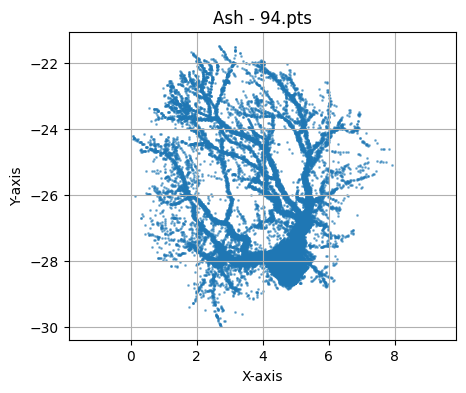


Processing Beech...
  File: 142.pts
  Points: 171,377


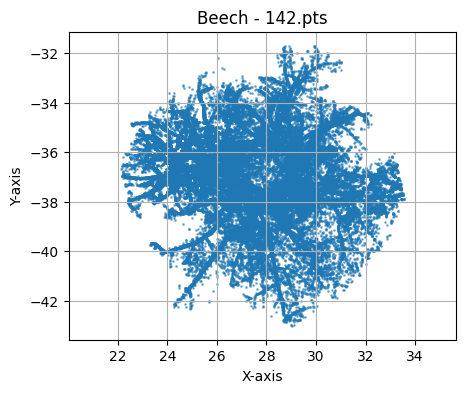


Processing Douglas Fir...
  File: Tree1_Interior.xyz
  Points: 803,163


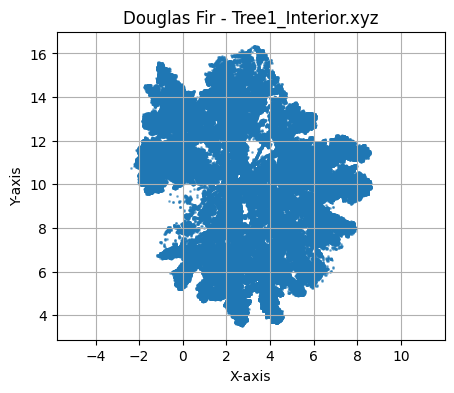


Processing Oak...
  File: 29.txt
  Points: 245,104


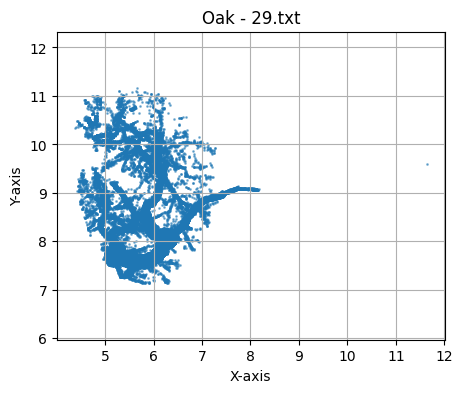


Processing Pine...
  File: Jerome_Ki2_SEW4.xyz
  Points: 270,639


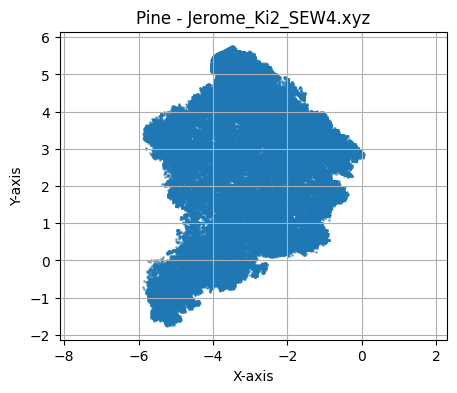


Processing Red Oak...
  File: Baum1_66 nrwl33- Cloud.txt
  Points: 86,251


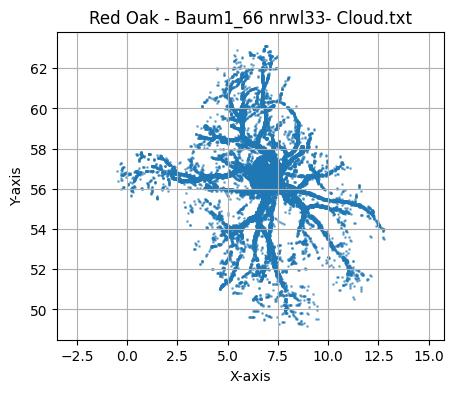


Processing Spruce...
  File: 65_38.txt
  Points: 83,637


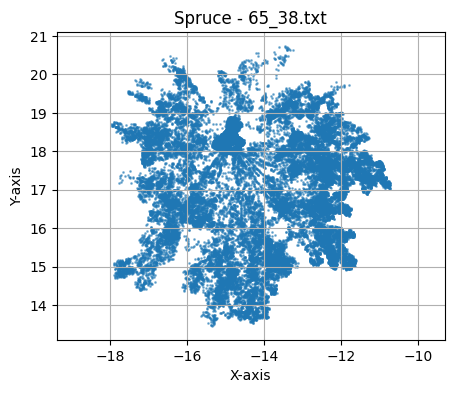

In [7]:
#using matploitlib for 2D visualization
def plot_point_cloud(pcd, title="Point Cloud"):
	"""
	Plots a 2D projection of the point cloud using matplotlib.
	If RGB colors are present, they are used for the scatter colors.
	"""
	if pcd is None:
		print("Cannot visualize an empty point cloud.")
		return
	
	points = np.asarray(pcd.points)
	colors = np.asarray(pcd.colors)
	c_arg = colors if colors.shape[0] == points.shape[0] else None
	
	# Create a 2D scatter plot
	plt.figure(figsize=(5, 4))
	plt.scatter(points[:, 0], points[:, 1], s=1, alpha=0.5, c=c_arg)
	plt.title(title)
	plt.xlabel("X-axis")
	plt.ylabel("Y-axis")
	plt.axis('equal')
	plt.grid(True)
	plt.show()

print("Loading and visualizing samples from each species in 2D...")
print("=" * 60)

for species in sorted(stats['train'].keys()):
	print(f"\nProcessing {species}...")
	
	sample_files = get_sample_files(species, "train", 1)
	
	if sample_files:
		sample_file = sample_files[0]
		point_cloud_obj = load_point_cloud(sample_file)
		
		if point_cloud_obj is not None:
			points_array = np.asarray(point_cloud_obj.points)
			print(f"  File: {sample_file.name}")
			print(f"  Points: {len(points_array):,}")
			
			# Plot the point cloud in 2D (with colors if available)
			plot_point_cloud(point_cloud_obj, f"{species} - {sample_file.name}")
		else:
			print(f"  Failed to load: {sample_file.name}")
	else:
		print(f"  No files found for {species}")

## 6. Point Cloud Properties Analysis

Analyze basic properties across different species to understand the data characteristics.

In [8]:
# Analyze properties across species
def analyze_point_cloud_properties(pcd):
    """Analyze basic properties of a point cloud"""
    if pcd is None:
        return None
    
    # Extract points array from Open3D PointCloud object
    points = np.asarray(pcd.points)
    
    if len(points) == 0:
        return None
    
    properties = {
        'num_points': len(points),
        'center': np.mean(points, axis=0),
        'min_bounds': np.min(points, axis=0),
        'max_bounds': np.max(points, axis=0),
        'extents': np.max(points, axis=0) - np.min(points, axis=0),
        'std_dev': np.std(points, axis=0)
    }
    
    # Calculate volume (bounding box)
    properties['bounding_volume'] = np.prod(properties['extents'])
    
    # Point density
    if properties['bounding_volume'] > 0:
        properties['point_density'] = properties['num_points'] / properties['bounding_volume']
    else:
        properties['point_density'] = 0
    
    return properties

# Collect properties for multiple samples per species
print("Analyzing point cloud properties across species...")
print("=" * 80)

species_properties = {}

for species in sorted(stats['train'].keys()):
    print(f"\nAnalyzing {species}...")
    
    # Get multiple samples for better statistics
    sample_files = get_sample_files(species, "train", 3)
    species_props = []
    
    for sample_file in sample_files:
        pcd = load_point_cloud(sample_file)
        props = analyze_point_cloud_properties(pcd)
        
        if props:
            species_props.append(props)
            print(f"  {sample_file.name}: {props['num_points']:,} points")
    
    if species_props:
        # Calculate average properties for this species
        avg_props = {}
        for key in ['num_points', 'bounding_volume', 'point_density']:
            values = [p[key] for p in species_props]
            avg_props[key] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values)
            }
        
        species_properties[species] = avg_props

# Display summary table
print(f"\nSummary of Point Cloud Properties")
print("=" * 80)
print(f"{'Species':<15} {'Avg Points':<15} {'Avg Volume':<15} {'Avg Density':<15}")
print("-" * 80)

for species, props in species_properties.items():
    avg_points = props['num_points']['mean']
    avg_volume = props['bounding_volume']['mean']
    avg_density = props['point_density']['mean']
    
    print(f"{species:<15} {avg_points:<15,.0f} {avg_volume:<15,.1f} {avg_density:<15,.2f}")

print("\nKey Observations:")
print("- Point count varies significantly between species")
print("- Density differences may indicate different scanning conditions")
print("- Volume differences reflect tree size variations")
print("\nNext step: Feature extraction (LBP + FPFH) for machine learning")

Analyzing point cloud properties across species...

Analyzing Ash...
  94.pts: 74,760 points
  156.pts: 51,983 points
  181.pts: 138,182 points

Analyzing Beech...
  142.pts: 171,377 points
  57.pts: 121,980 points
  43.pts: 78,832 points

Analyzing Douglas Fir...
  Tree1_Interior.xyz: 803,163 points
  Tree6_Interior.xyz: 927,032 points
  Tree15_Border.xyz: 1,586,162 points

Analyzing Oak...
  29.txt: 245,104 points
  15.txt: 240,851 points
  28.txt: 215,288 points

Analyzing Pine...
  Jerome_Ki2_SEW4.xyz: 270,639 points
  17.txt: 217,928 points
  13.txt: 146,832 points

Analyzing Red Oak...
  Baum1_66 nrwl33- Cloud.txt: 86,251 points
  Baum0_188 nrwl33- Cloud.txt: 78,427 points
  Baum5_350 nrwl33- Cloud.txt: 84,553 points

Analyzing Spruce...
  65_38.txt: 83,637 points
  65_10.txt: 73,635 points
  65_9.txt: 78,156 points

Summary of Point Cloud Properties
Species         Avg Points      Avg Volume      Avg Density    
-------------------------------------------------------------------